# Transfer Learning con MobileNetV2

Un modelo preentrenado es una red que ya se entrenó en un gran conjunto de datos y se guardó, lo que le permite usarlo para personalizar su propio modelo de manera económica y eficiente. El que usará, MobileNetV2, fue diseñado para proporcionar un rendimiento rápido y computacionalmente eficiente. Se ha entrenado previamente en ImageNet, un conjunto de datos que contiene más de 14 millones de imágenes y 1000 clases.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Conv2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
import warnings
warnings.filterwarnings('ignore')

# Debo importar de esta manera para traer image_data_from_directory
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

c:\Users\sandr\Anaconda3\envs\tensorflow\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


## 1.1 Creamos el Dataset y dividimos en conjuntos de entrenamiento y validación

Al entrenar y evaluar modelos de aprendizaje profundo en Keras, generar un conjunto de datos a partir de archivos de imágenes almacenados en el disco es simple y rápido. Llame a ***image_dataset_from_directory()*** para leer desde el directorio y crear conjuntos de datos de `entrenamiento` y `validación`.

Si está especificando una división de validación, también deberá especificar el subconjunto para cada parte. Simplemente configure el conjunto de entrenamiento en **subset='training'** y el conjunto de validación en **subset='validation'**

También configurará sus semillas para que coincidan entre sí, de modo que sus conjuntos de entrenamiento y validación no se superpongan.

└─dataset
    └─alpaca
    └─not alpaca

Usaremos el dataset de imagenes de alpaca de Kaggle: [Alpaca Dataset for Image Classification](https://www.kaggle.com/datasets/sid4sal/alpaca-dataset-small)

In [2]:
import os 

print("Las clases a identificar son:" )
print(os.listdir('dataset')[0], ": ", len(os.listdir('dataset/alpaca/')), " imagenes")
print(os.listdir('dataset')[1], ": ", len(os.listdir('dataset/not alpaca/')), " imagenes")

Las clases a identificar son:
alpaca :  142  imagenes
not alpaca :  185  imagenes


In [3]:
BATCH_SIZE = 32 
IMG_SIZE = (160, 160) # Forma correcta de entrada
directory = "dataset/"
train_dataset = image_dataset_from_directory(
    directory = directory,
    shuffle = True,
    batch_size = BATCH_SIZE,
    image_size = IMG_SIZE,
    validation_split = 0.2,
    subset = 'training',
    seed = 42
)

validation_dataset = image_dataset_from_directory(
    directory = directory,
    shuffle = True,
    batch_size = BATCH_SIZE,
    image_size = IMG_SIZE,
    validation_split = 0.2,
    subset = 'validation',
    seed = 42
)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


In [4]:
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

Ahora echemos un vistazo a algunas de las imágenes del training set:

In [5]:
class_names = train_dataset.class_names

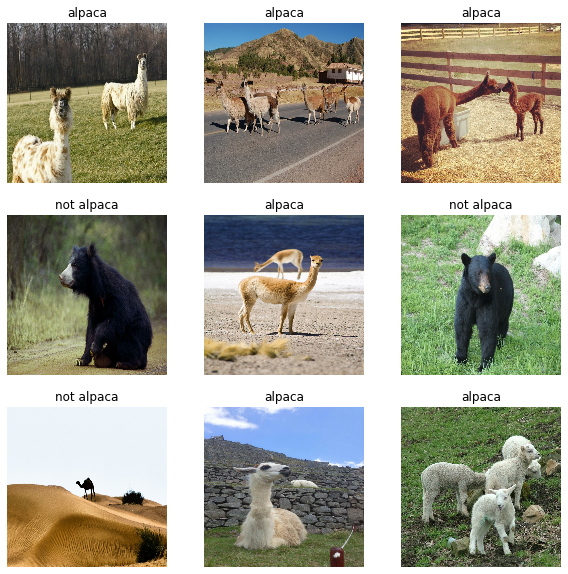

In [6]:
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        # print(images[i])  es un tensor
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis('off')

## 1.2 Preprocesamiento y Aumento de datos de entrenamiento

El uso de `prefetch()` evita un cuello de botella en la memoria que puede ocurrir al leer desde el disco. Reserva algunos datos y los mantiene listos para cuando se necesiten, creando un conjunto de datos de origen a partir de sus datos de entrada, aplicando una transformación para preprocesarlos y luego iterando sobre el conjunto de datos un elemento a la vez. Debido a que la iteración se transmite, los datos no necesitan caber en la memoria.

**Puede configurar el número de elementos para precargar manualmente**, o puede usar `tf.data.experimental.AUTOTUNE` **para elegir los parámetros automáticamente**. Autotune solicita `tf.data` *para ajustar ese valor dinámicamente en tiempo de ejecución*, rastreando el tiempo empleado en cada operación e ingresando esos tiempos en un algoritmo de optimización. El algoritmo de optimización intenta encontrar la mejor asignación de su presupuesto de CPU en todas las operaciones ajustables.


In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size = AUTOTUNE)

***Para aumentar la diversidad en el conjunto de entrenamiento y ayudar a su modelo a aprender mejor los datos***, es una práctica estándar aumentar las imágenes transformándolas, es decir, voltearlas y rotarlas aleatoriamente. La API secuencial de Keras ofrece un método sencillo para este tipo de aumentos de datos, con **capas de preprocesamiento integradas y personalizables**. Estas capas se guardan con el resto de su modelo y se pueden reutilizar más tarde. [here](https://www.tensorflow.org/tutorials/images/data_augmentation)

***data_augmenter***

Implementamos una función para el aumento de datos. Utiliza un modelo de keras secuencial compuesto por 2 capas:
- RandomFlip('horizontal')
- RandomRotation(0.2)

In [8]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2))
    return data_augmentation

Eche un vistazo a cómo se ha aumentado una imagen del conjunto de entrenamiento con transformaciones simples:
Desde un animal hasta 9 variaciones de ese animal

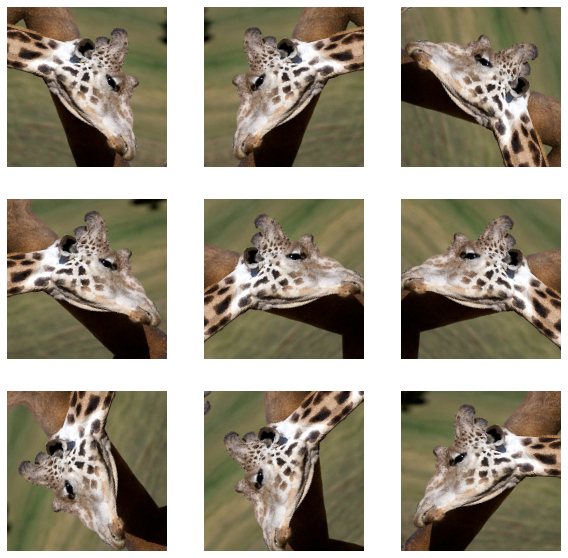

In [9]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1): # Un batch
    plt.figure(figsize=(10,10))
    first_image = image[0] # 1ra imagen de ese batch
    for i in range(9): # 9 variaciones de esa imagen
        ax = plt.subplot(3,3,i+1)
        augmented_image = data_augmentation(tf.expand_dims(input = first_image, axis = 0))
        plt.imshow(augmented_image[0]/255)
        plt.axis('off')


A continuación, aplicará su primera herramienta de la aplicación `MobileNet en TensorFlow` para normalizar su entrada. Dado que está utilizando un modelo previamente entrenado que **se entrenó en los valores de normalización [-1,1]**, es una buena práctica reutilizar ese estándar con:

```python
tf.keras.applications.mobilenet_v2.preprocess_input
```

In [10]:
# Normalizacion de los datos basandose en el modelo pre entrenado
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## 2.1 Usando MobileNetV2 para Transfer Learning

**MobileNetV2** se capacitó en ImageNet y está optimizado para ejecutarse en aplicaciones móviles y otras aplicaciones de bajo consumo. Tiene 155 capas de profundidad (en caso de que sintiera la necesidad de trazar el modelo usted mismo, ¡prepárese para un largo viaje!), Y es muy eficiente para tareas de *detección de objetos* y *segmentación de imágenes*, así como tareas de clasificación. La arquitectura tiene tres características definitorias:
- Depthwise separable convolutions
- Delgados bottlenecks de entrada y salida entre layers
- Shortcut connections entre bottleneck layers

### a). Dentro de un bloque de construcción convolucional MobileNetV2

MobileNetV2 usa **depthwise separable convolutions** como bloques de construcción eficientes. Las convoluciones tradicionales a menudo consumen muchos recursos, y las **convoluciones separables en profundidad** pueden reducir la cantidad de parámetros y operaciones entrenables y también acelerar las convoluciones en dos pasos:

1. El **primer paso** calcula un resultado intermedio convolucionando en cada uno de los canales de forma independiente. Este es el `depthwise convolution`.

2. En el **segundo paso**, otra convolución fusiona las salidas del paso anterior en una sola. Esto obtiene un solo resultado de una sola entidad a la vez y luego se aplica a todos los filtros en la capa de salida. Este es el `pointwise convolution`.

<img src="images/mobilenetv2.png" style="width:650px;height:450px;">
<caption><center> <a href="https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html#:~:text=MobileNetV2%20is%20a%20significant%20improvement,object%20detection%20and%20semantic%20segmentation."></a></center></caption>

Cada bloque consta de una `estructura residual invertida` con un cuello de botella en cada extremo. Estos cuellos de botella codifican las entradas y salidas intermedias en un espacio dimensional bajo y evitan que las no linealidades destruyan información importante.

Intentemos entrenar su ***modelo base usando todas las capas del modelo previamente entrenado.***

De manera similar a cómo reutilizó los valores de normalización preentrenados en los que se entrenó MobileNetV2, también ***cargará los pesos preentrenados de ImageNet*** especificando 
```python
weights='imagenet'
```

In [11]:
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)

In [12]:
# MobileNets admite cualquier tamaño de entrada superior a 32 x 32, 
# con tamaños de imagen más grandes que ofrecen un mejor rendimiento
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape = IMG_SHAPE, include_top = True, weights = 'imagenet' )

In [13]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

Tenga en cuenta las últimas 2 capas aquí. Son las llamadas top layer's, y son las responsables de la clasificación en el modelo.

In [15]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


- Las características únicas de MobileNetV2 son:
  - ***Convoluciones separables en profundidad*** que filtraron y crearon features ligeras
  - ***Cuellos de botella de entrada y salida*** que conservan información importante en cualquier extremo del bloque
- ***Las convoluciones separables en profundidad*** se ocupan de las dimensiones espaciales y de profundidad (número de canales)

Luego, elija el primer lote del conjunto de datos de tensorflow para usar las imágenes y ejecútelo a través del modelo base de MobileNetV2 para probar las predicciones en algunas de sus imágenes.

In [16]:
image_batch, label_batch = next(iter(train_dataset))

In [17]:
print("Cantidad de imagenes por lote: ", len(image_batch))
print("Etiquetas verdaderas de este batch: ", label_batch.numpy())

Cantidad de imagenes por lote:  32
Etiquetas verdaderas de este batch:  [1 0 0 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 0 1 0 0 0 1 0 1 1 1 1 0 0]


In [18]:
feature_batch = base_model(image_batch)
print("Forma de las predicciones del batch: ", feature_batch.shape)

Forma de las predicciones del batch:  (32, 1000)


In [19]:
feature_batch

<tf.Tensor: shape=(32, 1000), dtype=float32, numpy=
array([[4.9065566e-04, 1.0771545e-03, 1.0279362e-04, ..., 1.9107034e-05,
        1.9377089e-04, 2.2418311e-05],
       [5.1607451e-05, 1.4818569e-04, 1.5562745e-04, ..., 3.6341280e-05,
        2.7602059e-03, 1.5854466e-03],
       [2.0387370e-04, 2.0065534e-04, 4.0163992e-05, ..., 5.4130021e-05,
        9.4305084e-05, 4.9339367e-05],
       ...,
       [1.9512120e-04, 8.2999340e-04, 1.2341651e-05, ..., 1.5887821e-05,
        5.5141619e-04, 9.2102040e-05],
       [2.6014148e-05, 9.5155573e-04, 1.0843875e-05, ..., 1.2166398e-06,
        9.3880248e-05, 4.9567330e-05],
       [1.6515351e-04, 4.0905367e-04, 2.4291997e-04, ..., 1.6475763e-04,
        2.6773962e-03, 1.3426712e-04]], dtype=float32)>

Ahora decodifique las predicciones hechas por el modelo. Anteriormente, cuando imprimió la forma del lote, habría regresado (32, 1000).  Las predicciones devueltas por el modelo base a continuación siguen este formato:

`(número de clase,  etiqueta legible, probabilidad de la imagen)`

Notará que hay dos de estos devueltos para cada imagen en el lote: **estas son las dos probabilidades principales devueltas para esa imagen.**

In [24]:
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

In [25]:
# Decodifica la predicción de un modelo de ImageNet.
# top = 2 (las 2 mas probables)
tf.keras.applications.mobilenet_v2.decode_predictions(preds = pred.numpy(), top = 2)

[[('n04589890', 'window_screen', 0.42582303),
  ('n02708093', 'analog_clock', 0.09275514)],
 [('n04589890', 'window_screen', 0.23985922),
  ('n03887697', 'paper_towel', 0.14802623)],
 [('n04589890', 'window_screen', 0.7449462),
  ('n03598930', 'jigsaw_puzzle', 0.021948516)],
 [('n04589890', 'window_screen', 0.33545983),
  ('n03530642', 'honeycomb', 0.07628953)],
 [('n04589890', 'window_screen', 0.2732742),
  ('n03733281', 'maze', 0.08846927)],
 [('n04589890', 'window_screen', 0.6745236),
  ('n03530642', 'honeycomb', 0.07659889)],
 [('n04589890', 'window_screen', 0.79128546),
  ('n04209239', 'shower_curtain', 0.09241615)],
 [('n04589890', 'window_screen', 0.16463025),
  ('n03598930', 'jigsaw_puzzle', 0.087491065)],
 [('n03598930', 'jigsaw_puzzle', 0.37021396),
  ('n04589890', 'window_screen', 0.09956949)],
 [('n04589890', 'window_screen', 0.6161646),
  ('n03887697', 'paper_towel', 0.054876737)],
 [('n03530642', 'honeycomb', 0.25448892),
  ('n04589890', 'window_screen', 0.24874333)],
 [(

 Hay un montón de etiquetas aquí, pero ninguna de ellas dice "alpaca".

 Esto se debe a que MobileNet preentrenado sobre ImageNet no tiene las etiquetas correctas para alpacas, por lo que cuando usa el modelo completo, todo lo que obtiene es un montón de imágenes clasificadas incorrectamente.

Afortunadamente, puede **eliminar la capa superior**, que contiene todas las etiquetas de clasificación, y crear una nueva capa de clasificación.

## 2.2. Congelación de capas con Functional API

<img src="images/snowalpaca.png" style="width:400px;height:250px;">


Puedes lograr esto en tres pasos:

1. Eliminar la capa superior (la capa de clasificación)
   * Establecer `include_top` en base_model como false
2. Agregar una nueva capa clasificadora
   * Entrene solo una capa congelando el resto de la red
   * Como se mencionó anteriormente, una sola neurona es suficiente para resolver un problema de clasificación binaria.
3. Congele el modelo base y entrene la capa clasificadora recién creada
   * Establezca `base_model.trainable=False` para evitar cambiar los pesos y entrenar solo la nueva capa
   * Establezca el `training=False` en base_model para evitar realizar un seguimiento de las estadísticas en el **batchnorm layer**

In [48]:
global base_model
def alpaca_model(image_shape = IMG_SIZE, data_augmentation = data_augmenter()):
    input_shape = image_shape + (3,)
    # Modelo pre entrenado de MobileNetV2 con imagenet
    base_model = tf.keras.applications.MobileNetV2(input_shape = input_shape, include_top = False, weights = 'imagenet')
    # Congelamos las capas del modelo MobileNetV2
    base_model.trainable = False

    inputs = tf.keras.Input(input_shape)

    # Aplicamos la aumentacion de datos en las entradas
    X = data_augmentation(inputs)
    # Preprocesamiento de los datos (normalizacion misma que MobileNetV2)
    X = preprocess_input(X)

    # Establecemos training = False, para evitar que el batch normalization siga entrenandose
    X = base_model(X, training = False)

    # Añadimos las nuevas capas para la clasificacion binaria
    X = GlobalAveragePooling2D()(X)
    X = Dropout(0.2)(X)
    outputs = Dense(1)(X)

    model = Model(inputs,outputs)
    return model
    


Cree su nuevo modelo utilizando la función data_augmentation definida anteriormente.

In [49]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

In [50]:
model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

Compilamos el nuevo modelo y ejecutamos durante 5 epochs:

In [51]:
base_learning_rate = 0.01
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics = ['accuracy'])


In [52]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data = validation_dataset, epochs = initial_epochs, verbose = 2)

Epoch 1/5
9/9 - 15s - loss: 0.9964 - accuracy: 0.5954 - val_loss: 0.5399 - val_accuracy: 0.6154 - 15s/epoch - 2s/step
Epoch 2/5
9/9 - 5s - loss: 0.4595 - accuracy: 0.7901 - val_loss: 0.1033 - val_accuracy: 1.0000 - 5s/epoch - 591ms/step
Epoch 3/5
9/9 - 5s - loss: 0.3582 - accuracy: 0.8511 - val_loss: 0.0739 - val_accuracy: 0.9538 - 5s/epoch - 580ms/step
Epoch 4/5
9/9 - 5s - loss: 0.3048 - accuracy: 0.9046 - val_loss: 0.1034 - val_accuracy: 0.9385 - 5s/epoch - 557ms/step
Epoch 5/5
9/9 - 5s - loss: 0.2739 - accuracy: 0.8779 - val_loss: 0.0381 - val_accuracy: 1.0000 - 5s/epoch - 596ms/step


Plot the training and validation accuracy:

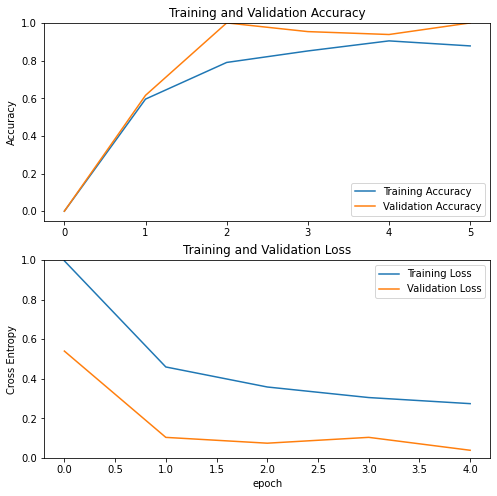

In [53]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (8,8))
plt.subplot(2,1,1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2,1,2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [54]:
class_names

['alpaca', 'not alpaca']

## 3. Fine-turning del Modelo

Para lograr esto, simplemente descongele las capas finales y vuelva a ejecutar el optimizador con una tasa de aprendizaje menor, mientras mantiene todas las demás capas congeladas.

**La intuición de lo que está sucediendo:** cuando la red se encuentra en sus primeras etapas, se entrena en features de bajo nivel, como los bordes. En las capas posteriores, comienzan a emerger features más complejas y de alto nivel, como cabello ralo u orejas puntiagudas. Para el `aprendizaje por transferencia`, los features de bajo nivel se pueden mantener iguales, ya que tienen features comunes para la mayoría de las imágenes. Cuando agrega nuevos datos, generalmente desea que las features de alto nivel se adapten a ellos, lo que es como dejar que la red aprenda a detectar features más relacionadas con sus datos, como un pelaje suave o dientes grandes.

El *lugar donde comienzan las capas finales es un poco arbitrario*, así que siéntase libre de jugar un poco con este número. La conclusión importante es que `las últimas capas son la parte de su red que contiene los detalles finos` (orejas puntiagudas, colas peludas) que son más específicos para su problema.

Primero, descongele el modelo base configurando
```python 
base_model.trainable=True
```
luego vuelva a congelar todas las capas anteriores. Vuelva a ejecutarlo durante algunas epochs más y vea si su accuracy mejoró.

In [55]:
model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [56]:
base_model.trainable = True


In [57]:
print("Numero de capas en el modelo base: ", len(base_model.layers))
print("Numero de capas del modelo actual: ", len(model2.layers))

Numero de capas en el modelo base:  156
Numero de capas del modelo actual:  8


El `model2` incluye el base_model(include_top = False), por ende modificando(descongelando capas) el `base_model` completaría al `model2` a estar completamente descongelado

In [58]:
# Afinar desde esta capa en adelante
fine_tune_at = 126
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [59]:
model2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate*0.1),
               loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
               metrics = ["accuracy"])

In [60]:
# Historial de epochs, del anterior entrenamiento
history.epoch

[0, 1, 2, 3, 4]

In [61]:
fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset, 
                          epochs = total_epochs,
                          initial_epoch = history.epoch[-1],
                          validation_data = validation_dataset,
                          verbose = 2)

Epoch 5/10
9/9 - 16s - loss: 0.2102 - accuracy: 0.9084 - val_loss: 0.0760 - val_accuracy: 0.9692 - 16s/epoch - 2s/step
Epoch 6/10
9/9 - 5s - loss: 0.1836 - accuracy: 0.9237 - val_loss: 0.0444 - val_accuracy: 0.9846 - 5s/epoch - 544ms/step
Epoch 7/10
9/9 - 5s - loss: 0.1681 - accuracy: 0.9389 - val_loss: 0.0422 - val_accuracy: 0.9846 - 5s/epoch - 565ms/step
Epoch 8/10
9/9 - 5s - loss: 0.1238 - accuracy: 0.9351 - val_loss: 0.0416 - val_accuracy: 0.9846 - 5s/epoch - 561ms/step
Epoch 9/10
9/9 - 5s - loss: 0.1556 - accuracy: 0.9008 - val_loss: 0.0428 - val_accuracy: 0.9846 - 5s/epoch - 543ms/step
Epoch 10/10
9/9 - 5s - loss: 0.1611 - accuracy: 0.9313 - val_loss: 0.0419 - val_accuracy: 0.9846 - 5s/epoch - 543ms/step


In [62]:
history_fine.epoch

[4, 5, 6, 7, 8, 9]

¡Ahhh, toda una mejora!

In [63]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

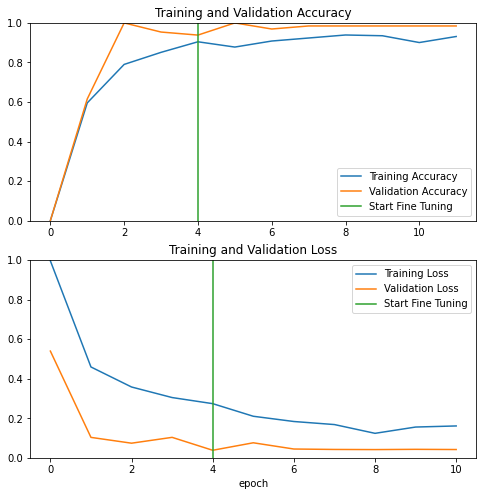

In [64]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.ylim([0,1])
plt.plot([initial_epochs-1, initial_epochs-1],
          plt.ylim(), label = 'Start Fine Tuning')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(2,1,2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.ylim([0,1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<font color='azul'>

**Lo que debes recordar**:

* Para adaptar el clasificador a nuevos datos: elimine la capa superior, agregue una nueva capa de clasificación y entrene solo en esa capa
* Al congelar capas, evite realizar un seguimiento de las estadísticas (como en la capa de normalización por lotes)
* Ajuste las capas finales de su modelo para capturar detalles de alto nivel cerca del final de la red y mejorar potencialmente el accuracy 